In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import math
import string
import textblob

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def preprocess_text(text) :
  full_line = text 
  full_line = re.sub(r'#([^ ]*)', r'\1', full_line)
  full_line = re.sub(r'https.*[^ ]', 'URL', full_line)
  full_line = re.sub(r'http.*[^ ]', 'URL', full_line)
  full_line = re.sub(r'@([^ ]*)', '@USER', full_line)
  full_line = re.sub(r'(:.*?:)', r' \1 ', full_line)
  full_line = re.sub(' +', ' ', full_line)
  full_line = re.sub('\n', '', full_line)
  full_line = re.sub('>', '', full_line)
  return full_line


def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
>>> import nltk
>>> nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Combine dataframe

In [ ]:
# Himanshu
# reddit_path = '/content/drive/MyDrive/DASC-Datasets/reddit_hatespeech_dataset.csv'
# gab_path = '/content/drive/MyDrive/DASC-Datasets/gab_hatespeech_dataset.csv'

# Kiet
reddit_path = '/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Hatespeech/reddit_hatespeech_dataset.csv'
gab_path = '/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Hatespeech/gab_hatespeech_dataset.csv'

# #Laren
# reddit_path = '/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Hatespeech/reddit_hatespeech_dataset.csv'
# gab_path = '/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Hatespeech/gab_hatespeech_dataset.csv'

df_r = pd.read_csv(reddit_path)
df_g = pd.read_csv(gab_path)
df = pd.concat([df_r, df_g])
df = df.reset_index(drop=True)
df['text'] = df.dropna()
df = df.reset_index(drop=True)
df['tokens'] = df['text'].fillna('').astype(str).map(preprocess)
df

,text,label,tokens
0,a subsection of retarded hungarians? ohh boy. ...,1,"[subsection, retard, hungarians, ohh, boy, bra..."
1,hiii. just got off work. 444 is mainly the typ...,0,"[hiii, get, work, mainly, typa, guy, imagine, ..."
2,wow i guess soyboys are the same in every country,0,"[wow, guess, soyboys, country]"
3,owen benjamin's soyboy song goes for every cou...,0,"[owen, benjamin, soyboy, song, go, country, am..."
4,"""y'all hear sumn?"" by all means i live in a sm...",0,"[hear, sumn, mean, live, small, town, work, pe..."
...,...,...,...
48987,fucking retard,1,"[fuck, retard]"
48988,twitter banned me and reported me to the fbi f...,0,"[twitter, ban, report, fbi, state, obvious, or..."
48989,"i was routinely suspended for saying fuck, and...",1,"[routinely, suspend, say, fuck, ban, call, pro..."
48990,they got me for dropping the cunt bomb... a lot.,1,"[get, drop, cunt, bomb, lot]"


In [ ]:
# df.to_csv('combined_data.csv')

In [ ]:
# df['tokens'] = df['text'].apply(preprocess)

TFIDF Calculation

In [ ]:
# def identity_tokenizer(text):
#   return text

# tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    
# tfidf_wm = tfidf.fit_transform(df['tokens'])

## Features

In [ ]:
df['char_count'] = df['text'].fillna('').astype(str).map(len)
df['word_count'] = df['text'].fillna('').astype(str).map(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].fillna('').astype(str).map(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
# df['title_word_count'] = df['text'].fillna('').astype(str).map(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# df['upper_case_word_count'] = df['text'].fillna('').astype(str).map(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] =  df['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] =  df['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] = df['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] = df['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'pron'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df

,text,label,tokens,char_count,word_count,word_density,punctuation_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,a subsection of retarded hungarians? ohh boy. ...,1,"[subsection, retard, hungarians, ohh, boy, bra...",146,26,5.407407,3,8,3,3,1,1
1,hiii. just got off work. 444 is mainly the typ...,0,"[hiii, get, work, mainly, typa, guy, imagine, ...",252,46,5.361702,5,9,8,8,4,6
2,wow i guess soyboys are the same in every country,0,"[wow, guess, soyboys, country]",49,10,4.454545,0,5,1,1,0,0
3,owen benjamin's soyboy song goes for every cou...,0,"[owen, benjamin, soyboy, song, go, country, am...",82,14,5.466667,4,4,3,1,2,1
4,"""y'all hear sumn?"" by all means i live in a sm...",0,"[hear, sumn, mean, live, small, town, work, pe...",318,54,5.781818,17,18,12,4,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...
48987,fucking retard,1,"[fuck, retard]",14,2,4.666667,0,1,1,0,0,0
48988,twitter banned me and reported me to the fbi f...,0,"[twitter, ban, report, fbi, state, obvious, or...",374,73,5.054054,9,22,12,5,3,9
48989,"i was routinely suspended for saying fuck, and...",1,"[routinely, suspend, say, fuck, ban, call, pro...",217,35,6.027778,5,14,9,3,2,0
48990,they got me for dropping the cunt bomb... a lot.,1,"[get, drop, cunt, bomb, lot]",48,10,4.363636,4,3,2,0,0,2


# PCA

In [ ]:
features_df = df[['char_count','word_count',	'word_density',	'punctuation_count',	'noun_count',	'verb_count',	'adj_count',	'adv_count',	'pron_count', 'label']]
features_df

#
# Perform one-hot encoding
#
categorical_columns = features_df.columns[features_df.dtypes == object] # Find all categorical columns
 
features_df = pd.get_dummies(features_df, columns = categorical_columns, drop_first=True)
#
# Create training / test split
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(features_df[features_df.columns[features_df.columns != 'label']],
                   features_df['label'], test_size=0.25, random_state=1)

#
# Standardize the dataset; This is very important before you apply PCA
#
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
#
# Perform PCA
#
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

def performPCAandTestWithRF(k):
  pca = PCA(n_components=k)
  #
  # Determine transformed features
  #
  X_train_pca = pca.fit_transform(X_train_std)
  X_test_pca = pca.transform(X_test_std)

  clf = RandomForestClassifier(n_estimators=100, random_state=0)
  clf.fit(X_train_pca, y_train)
  y_pred = clf.predict(X_test_pca)

  #Import scikit-learn metrics module for accuracy calculation
  from sklearn import metrics
  # Model Accuracy, how often is the classifier correct?
  print("Accuracy for k =",k,":",metrics.accuracy_score(y_test, y_pred))

values = [3,4,5,6,7,8,9,10]
for k in values:
  performPCAandTestWithRF(k)

Accuracy for k = 3 : 0.5912802090137165
Accuracy for k = 4 : 0.598791639451339
Accuracy for k = 5 : 0.6089157413455258
Accuracy for k = 6 : 0.6121815806662312
Accuracy for k = 7 : 0.6100587851077727
Accuracy for k = 8 : 0.6205094709340301
Accuracy for k = 9 : 0.6217341606792945


ValueError: ignored

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy w/o PCA:", metrics.accuracy_score(y_test, y_pred))

Accuracy w/o PCA: 0.6145493141737427


LDA as feature

In [ ]:
dict_ = corpora.Dictionary(df['tokens'])
print(dict_)
doc_term_matrix = [dict_.doc2bow(i) for i in df['tokens']]

lda = gensim.models.ldamodel.LdaModel
lda_model = lda(doc_term_matrix, num_topics=2, id2word=dict_, passes=1, random_state=0, eval_every=None)
print(lda_model.print_topics(num_topics=2, num_words=10))

lda_label = []
count = 0 
for i in lda_model[doc_term_matrix] :
  # print("doc: ",count, i)
  try :
    a = i[0][1]
  except:
    a = int(0)
  try :
    b = i[1][1]
  except :
    b = int(0)

  if(a>b) :
    lda_label.append(float(0))
  else :
    lda_label.append(float(1))
  count+=1

Dictionary(32956 unique tokens: ['boy', 'brace', 'bulbasaur', 'come', 'countrymen']...)
[(0, '0.021*"nigger" + 0.019*"user" + 0.016*"white" + 0.015*"retard" + 0.011*"like" + 0.010*"people" + 0.008*"fuck" + 0.007*"faggot" + 0.006*"jews" + 0.006*"trump"'), (1, '0.019*"url" + 0.012*"gifwar" + 0.010*"faggot" + 0.008*"cunt" + 0.008*"like" + 0.008*"fuck" + 0.006*"get" + 0.005*"say" + 0.005*"go" + 0.005*"know"')]


##Column Transformer

In [ ]:
def combine(tokens) :
  s = ''
  for w in tokens :
    s = s + w + " "
  return s.strip() 

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
transform = ColumnTransformer(
    [('description_tfidf', TfidfVectorizer(stop_words = 'english'), 'token_text')],
    remainder='passthrough')

df['token_text'] = df['tokens'].apply(combine)
df['lda'] = lda_label

In [ ]:
# df.to_csv('/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Hatespeech/df_with_features.csv', index=False)

##Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/DASC-Datasets/df_with_features.csv")

In [ ]:
X = df[['char_count','word_count',	'word_density',	'punctuation_count',	'noun_count',	'verb_count',	'adj_count',	'adv_count',	'pron_count', 'token_text', 'lda']]
y = df['label']

X

,char_count,word_count,word_density,punctuation_count,noun_count,verb_count,adj_count,adv_count,pron_count,token_text,lda
0,146,26,5.407407,3,8,3,3,1,1,subsection retard hungarians ohh boy brace liv...,1.0
1,252,46,5.361702,5,9,8,8,4,6,hiii get work mainly typa guy imagine write st...,1.0
2,49,10,4.454545,0,5,1,1,0,0,wow guess soyboys country,1.0
3,82,14,5.466667,4,4,3,1,2,1,owen benjamin soyboy song go country amaze,0.0
4,318,54,5.781818,17,18,12,4,6,3,hear sumn mean live small town work people ori...,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48987,14,2,4.666667,0,1,1,0,0,0,fuck retard,0.0
48988,374,73,5.054054,9,22,12,5,3,9,twitter ban report fbi state obvious order thr...,1.0
48989,217,35,6.027778,5,14,9,3,2,0,routinely suspend say fuck ban call prominent ...,1.0
48990,48,10,4.363636,4,3,2,0,0,2,get drop cunt bomb lot,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Run data on Models**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_recall_fscore_support

def compute_ROC_data(model, X_test, y_test):
  lr_probs = model.predict_proba(X_test)
  lr_probs = lr_probs[:, 1]
  lr_auc = roc_auc_score(y_test, lr_probs)

  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

  return lr_auc, lr_fpr, lr_tpr

# Random Forest

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score , classification_report

rf_model = make_pipeline(transform, RandomForestClassifier(n_estimators=100))
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('description_tfidf',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'token_text')])),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
np.save('/content/drive/MyDrive/DASC-Datasets/y_test.npy', y_test)

In [ ]:
def get_result(model, X_test, y_test):
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  c_rep = classification_report(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("accuracy:", accuracy)
  print("f1:", f1)
  print("c_rep:", c_rep)


get_result(rf_model, X_test, y_test)
rf_auc, rf_fpr, rf_tpr = compute_ROC_data(rf_model, X_test, y_test)
print("AUC:", rf_auc)

accuracy: 0.9223390141851209
f1: 0.8988704318936876
c_rep:               precision    recall  f1-score   support

           0       0.92      0.96      0.94      5894
           1       0.93      0.87      0.90      3905

    accuracy                           0.92      9799
   macro avg       0.92      0.91      0.92      9799
weighted avg       0.92      0.92      0.92      9799

AUC: 0.956425293284214


# Naive Bayes

In [ ]:
nb_model = make_pipeline(transform, naive_bayes.MultinomialNB())
nb_model.fit(X_train, y_train)

get_result(nb_model, X_test, y_test)
nb_auc, nb_fpr, nb_tpr = compute_ROC_data(nb_model, X_test, y_test)
print("AUC:", nb_auc)

accuracy: 0.8228390652107358
f1: 0.7369696969696969
c_rep:               precision    recall  f1-score   support

           0       0.79      0.96      0.87      5894
           1       0.90      0.62      0.74      3905

    accuracy                           0.82      9799
   macro avg       0.85      0.79      0.80      9799
weighted avg       0.84      0.82      0.81      9799

AUC: 0.876143733487081


# Linear Model

In [ ]:
from sklearn import linear_model
linear_model = make_pipeline(transform, linear_model.LogisticRegression())
linear_model.fit(X_train, y_train)

get_result(linear_model, X_test, y_test)
ln_auc, ln_fpr, ln_tpr = compute_ROC_data(linear_model, X_test, y_test)
print("AUC:", ln_auc)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy: 0.77701806306766
f1: 0.6770140428677014
c_rep:               precision    recall  f1-score   support

           0       0.77      0.90      0.83      5894
           1       0.80      0.59      0.68      3905

    accuracy                           0.78      9799
   macro avg       0.78      0.74      0.75      9799
weighted avg       0.78      0.78      0.77      9799

AUC: 0.8218298562699887


# SVM

In [ ]:
svm_model = make_pipeline(transform, svm.SVC(kernel='linear'))
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

# XGBoost

In [ ]:
import xgboost

boosting_model = make_pipeline(transform, xgboost.XGBClassifier())
boosting_model.fit(X_train, y_train)

get_result(boosting_model, X_test, y_test)
boosting_auc, boosting_fpr, boosting_tpr = compute_ROC_data(boosting_model, X_test, y_test)
print("AUC:", boosting_auc)

accuracy: 0.9190733748341667
f1: 0.889845811918322
c_rep:               precision    recall  f1-score   support

           0       0.89      0.98      0.94      5894
           1       0.97      0.82      0.89      3905

    accuracy                           0.92      9799
   macro avg       0.93      0.90      0.91      9799
weighted avg       0.92      0.92      0.92      9799

AUC: 0.9411348679422681


## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = make_pipeline(transform, AdaBoostClassifier(n_estimators=100))
adaboost_model.fit(X_train,y_train)

get_result(adaboost_model, X_test, y_test)
ada_auc, ada_fpr, ada_tpr = compute_ROC_data(adaboost_model, X_test, y_test)
print("AUC:", ada_auc)

accuracy: 0.9269313195224003
f1: 0.9032432432432432
c_rep:               precision    recall  f1-score   support

           0       0.91      0.97      0.94      5894
           1       0.96      0.86      0.90      3905

    accuracy                           0.93      9799
   macro avg       0.93      0.91      0.92      9799
weighted avg       0.93      0.93      0.93      9799

AUC: 0.9506137450920161


In [ ]:
# X_train

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,token_text,lda
38864,219,33,6.441176,3,0,0,8,7,4,4,1,average celebretard eighth grade education lea...,1.0
19683,14,3,3.500000,1,0,0,0,1,0,0,1,work,1.0
20755,88,14,5.866667,7,0,0,7,3,1,1,1,stephen colbert late writer glad ruin brett ka...,1.0
11118,174,33,5.117647,9,0,0,11,3,3,4,2,god open shut case johnson saw rookie apparent...,0.0
2453,16,2,5.333333,3,0,0,2,1,0,0,0,remove,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,98,18,5.157895,7,0,0,3,3,5,3,0,true fair replace white man black man similar ...,1.0
44732,282,51,5.423077,5,0,0,17,15,3,4,4,shitbags want score point disease ride sjw bit...,0.0
38158,119,19,5.950000,3,0,0,5,2,3,2,1,right zero white people welfare die shitty ide...,0.0
860,77,15,4.812500,2,0,0,0,4,3,0,2,special unable score special retard,0.0


## LGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model =make_pipeline(transform, LGBMClassifier(objective='binary', random_state=5)) 
lgbm_model.fit(X_train,y_train)

get_result(lgbm_model, X_test, y_test)
lgbm_auc, lgbm_fpr, lgbm_tpr = compute_ROC_data(lgbm_model, X_test, y_test)
print("AUC:", lgbm_auc)

accuracy: 0.9288702928870293
f1: 0.9061026539135121
c_rep:               precision    recall  f1-score   support

           0       0.91      0.97      0.94      5894
           1       0.96      0.86      0.91      3905

    accuracy                           0.93      9799
   macro avg       0.93      0.92      0.92      9799
weighted avg       0.93      0.93      0.93      9799

AUC: 0.9605917952109112


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = make_pipeline(transform, DecisionTreeClassifier()) 
dt_model.fit(X_train, y_train)

get_result(dt_model, X_test, y_test)
dt_auc, dt_fpr, dt_tpr = compute_ROC_data(dt_model, X_test, y_test)
print("AUC:", dt_auc)

accuracy: 0.9111133789162159
f1: 0.886485077544637
c_rep:               precision    recall  f1-score   support

           0       0.92      0.94      0.93      5894
           1       0.90      0.87      0.89      3905

    accuracy                           0.91      9799
   macro avg       0.91      0.90      0.91      9799
weighted avg       0.91      0.91      0.91      9799

AUC: 0.9061122728597888


In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = AdaBoostClassifier(n_estimators=100)
clf2 = RandomForestClassifier(n_estimators=100)
clf3 = LGBMClassifier(objective='binary', random_state=5)

eclf1 = VotingClassifier(estimators=[('lr',clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

vt_model = make_pipeline(transform, eclf1)
vt_model = vt_model.fit(X_train, y_train)

In [ ]:
get_result(vt_model, X_test, y_test)
vt_auc, vt_fpr, vt_tpr = compute_ROC_data(vt_model, X_test, y_test)
print("AUC:", vt_auc)

accuracy: 0.9285641391978773
f1: 0.9060654857756308
c_rep:               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5894
           1       0.95      0.86      0.91      3905

    accuracy                           0.93      9799
   macro avg       0.93      0.92      0.92      9799
weighted avg       0.93      0.93      0.93      9799

AUC: 0.9620738032166221


## PLOT ROC CURVE

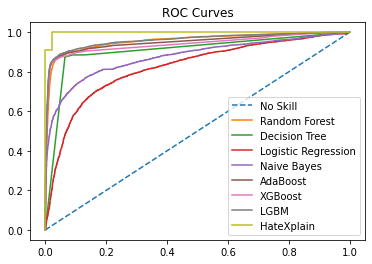

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# lr_probs = lgbm_model.predict_proba(X_test)
# lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
# lr_auc = roc_auc_score(y_test, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# rf_auc, rf_fpr, rf_tpr
he_fpr = np.load('/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Copy of hateXplain_fpr.npy')
he_tpr= np.load('/content/drive/MyDrive/Classroom/Data Analytics/Term Project/Copy of hateXplain_tpr.npy')
plt.plot(ns_fpr, ns_tpr, linestyle='dashed', label='No Skill')

plt.plot(rf_fpr, rf_tpr, linestyle= 'solid', label='Random Forest')
plt.plot(dt_fpr, dt_tpr, linestyle= 'solid', label='Decision Tree')
plt.plot(ln_fpr, ln_tpr, linestyle= 'solid', label='Logistic Regression')
plt.plot(nb_fpr, nb_tpr, linestyle= 'solid', label='Naive Bayes')
plt.plot(ada_fpr, ada_tpr, linestyle= 'solid', label='AdaBoost')
plt.plot(boosting_fpr, boosting_tpr, linestyle= 'solid', label='XGBoost')
plt.plot(lgbm_fpr, lgbm_tpr, linestyle= 'solid', label='LGBM')
plt.plot(he_fpr, he_tpr, linestyle= 'solid', label='HateXplain')

plt.legend()
plt.title('ROC Curves')
plt.show()

In [ ]:
print("LGBM AUC:", lgbm_auc)

LGBM AUC: 0.9605917952109112


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_lgbm)
f1

0.9061026539135121

In [ ]:
hatecheck_data = pd.read_csv('/content/drive/MyDrive/Classroom/Data Analytics/Term Project/test_suite_cases.csv')
hatecheck_data = hatecheck_data.rename(columns={'test_case': 'text', 'label_gold': 'label'})
hatecheck_data = hatecheck_data[['text','label']]
hatecheck_data = hatecheck_data.replace('non-hateful',1)
hatecheck_data = hatecheck_data.replace('hateful',0)
# hatecheck_data.to_csv('hatecheck_labeled.csv', index=False)
hatecheck_data

,text,label
0,I hate women.,0
1,I hate trans people.,0
2,I hate gay people.,0
3,I hate black people.,0
4,I hate disabled people.,0
...,...,...
3723,Gay people are all complete 4ssholes.,0
3724,Black people are all complete 4ssholes.,0
3725,Disabled people are all complete 4ssholes.,0
3726,Muslims are all complete 4ssholes.,0


In [ ]:
def to_lower(text) :
  return text.lower()

In [ ]:
hatecheck_data['text_lower'] = hatecheck_data['text'].apply(to_lower)

In [ ]:
hatecheck_data

,text,label,text_lower
0,I hate women.,0,i hate women.
1,I hate trans people.,0,i hate trans people.
2,I hate gay people.,0,i hate gay people.
3,I hate black people.,0,i hate black people.
4,I hate disabled people.,0,i hate disabled people.
...,...,...,...
3723,Gay people are all complete 4ssholes.,0,gay people are all complete 4ssholes.
3724,Black people are all complete 4ssholes.,0,black people are all complete 4ssholes.
3725,Disabled people are all complete 4ssholes.,0,disabled people are all complete 4ssholes.
3726,Muslims are all complete 4ssholes.,0,muslims are all complete 4ssholes.


In [ ]:
hatecheck_data['char_count'] = hatecheck_data['text'].fillna('').astype(str).map(len)
hatecheck_data['word_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: len(x.split()))
hatecheck_data['word_density'] = hatecheck_data['char_count'] / (hatecheck_data['word_count']+1)
hatecheck_data['punctuation_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
# hatecheck_data['title_word_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
# hatecheck_data['upper_case_word_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
hatecheck_data['tokens'] = hatecheck_data['text'].fillna('').astype(str).map(preprocess)

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

hatecheck_data['noun_count'] =  hatecheck_data['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'noun'))
hatecheck_data['verb_count'] =  hatecheck_data['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'verb'))
hatecheck_data['adj_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'adj'))
hatecheck_data['adv_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'adv'))
hatecheck_data['pron_count'] = hatecheck_data['text'].fillna('').astype(str).map(lambda x: check_pos_tag(x, 'pron'))

dict_ = corpora.Dictionary(hatecheck_data['tokens'])
print(dict_)
doc_term_matrix = [dict_.doc2bow(i) for i in hatecheck_data['tokens']]

lda = gensim.models.ldamodel.LdaModel
lda_model = lda(doc_term_matrix, num_topics=2, id2word=dict_, passes=1, random_state=0, eval_every=None)
print(lda_model.print_topics(num_topics=2, num_words=10))

lda_label = []
count = 0 
for i in lda_model[doc_term_matrix] :
  # print("doc: ",count, i)
  try :
    a = i[0][1]
  except:
    a = int(0)
  try :
    b = i[1][1]
  except :
    b = int(0)

  if(a>b) :
    lda_label.append(float(0))
  else :
    lda_label.append(float(1))
  count+=1

hatecheck_data['token_text'] = hatecheck_data['tokens'].apply(combine)
hatecheck_data['lda'] = lda_label

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Dictionary(973 unique tokens: ['hate', 'women', 'people', 'trans', 'gay']...)
[(0, '0.152*"people" + 0.042*"disable" + 0.038*"black" + 0.036*"gay" + 0.036*"trans" + 0.032*"like" + 0.021*"live" + 0.019*"person" + 0.016*"typical" + 0.014*"say"'), (1, '0.041*"like" + 0.038*"muslims" + 0.035*"immigrants" + 0.034*"women" + 0.025*"people" + 0.018*"country" + 0.018*"person" + 0.012*"trans" + 0.012*"muslim" + 0.012*"gay"')]


In [ ]:
# hatecheck_train = hatecheck_data[['']]

hatecheck_X = hatecheck_data[['char_count','word_count',	'word_density',	'punctuation_count',	'noun_count',	'verb_count',	'adj_count',	'adv_count',	'pron_count', 'token_text', 'lda']]
hatecheck_label = hatecheck_data['label']
hatecheck_X

,char_count,word_count,word_density,punctuation_count,noun_count,verb_count,adj_count,adv_count,pron_count,token_text,lda
0,14,3,3.500000,1,1,1,0,0,1,hate women,0.0
1,21,4,4.200000,1,2,1,0,0,1,hate trans people,0.0
2,19,4,3.800000,1,1,1,1,0,1,hate gay people,0.0
3,21,4,4.200000,1,1,1,1,0,1,hate black people,0.0
4,24,4,4.800000,1,1,1,1,0,1,hate disable people,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3723,38,6,5.428571,1,1,1,2,0,0,gay people complete ssholes,0.0
3724,40,6,5.714286,1,2,1,1,0,0,black people complete ssholes,0.0
3725,43,6,6.142857,1,1,1,2,0,0,disable people complete ssholes,0.0
3726,35,5,5.833333,1,1,1,1,0,0,muslims complete ssholes,1.0


In [ ]:
# y_pred_hc = lgbm_model.predict(hatecheck_X)
# accuracy = accuracy_score(hatecheck_label, y_pred_hc)
# c_rep = classification_report(hatecheck_label, y_pred_hc)
# print(accuracy)
# print(c_rep)


get_result(lgbm_model, hatecheck_X, hatecheck_label)
hc_auc, _, _ = compute_ROC_data(lgbm_model, hatecheck_X, hatecheck_label)
print("AUC:", hc_auc)

accuracy: 0.7022532188841202
f1: 0.1641566265060241
c_rep:               precision    recall  f1-score   support

           0       0.70      0.98      0.82      2563
           1       0.67      0.09      0.16      1165

    accuracy                           0.70      3728
   macro avg       0.69      0.54      0.49      3728
weighted avg       0.69      0.70      0.61      3728

AUC: 0.4860520882348509
